# Assignment 4: GMM-Based Synthetic Sampling for Imbalanced Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## Part A: Baseline Model and Data Analysis

In [3]:
# Load creditcard.csv dataset
df = pd.read_csv('data/creditcard.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (284807, 31)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20  

## Analysing Class Distribution

Class Distribution:
Non-fraudulent: 284,315
Fraudulent: 492
Imbalance Ratio: 577.9:1


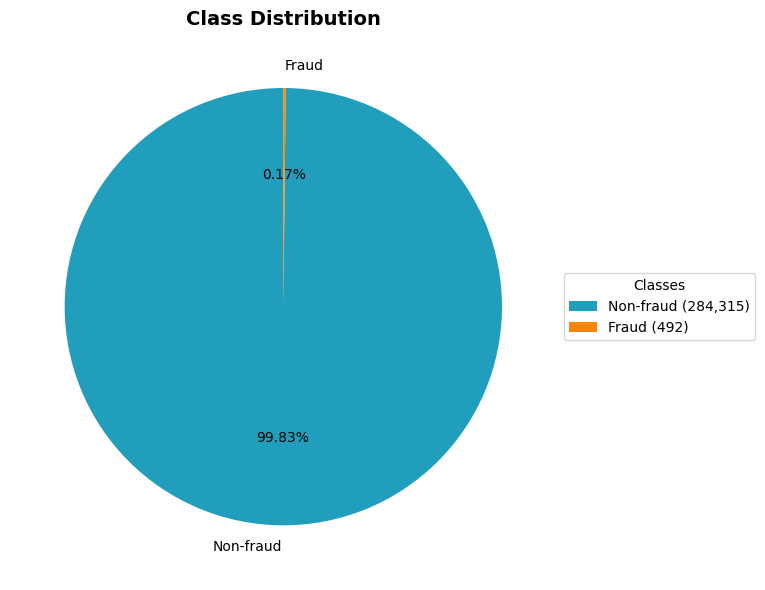

In [5]:
# Class Distribution Analysis
class_counts = df['Class'].value_counts()
print("Class Distribution:")
print(f"Non-fraudulent: {class_counts[0]:,}")
print(f"Fraudulent: {class_counts[1]:,}")
print(f"Imbalance Ratio: {class_counts[0]/class_counts[1]:.1f}:1")

# Visualization
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(class_counts.values, labels=['Non-fraud', 'Fraud'], 
                                   autopct='%1.2f%%', startangle=90, 
                                   colors=['#219ebc', '#fb8500'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')

# Add legend
plt.legend(wedges, [f'Non-fraud ({class_counts[0]:,})', f'Fraud ({class_counts[1]:,})'], 
           title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

## Model Training

In [6]:
# Prepare features and target
X = df.drop('Class', axis=1)
y = df['Class']

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

# Split dataset into training and testing sets
# Using stratified split to maintain class imbalance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensures test set reflects original class imbalance
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Verify class distribution is maintained
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"Training set imbalance ratio: {y_train.value_counts()[0]/y_train.value_counts()[1]:.1f}:1")

print(f"\nTest set class distribution:")
print(y_test.value_counts())
print(f"Test set imbalance ratio: {y_test.value_counts()[0]/y_test.value_counts()[1]:.1f}:1")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled successfully")
print(f"Training features shape after scaling: {X_train_scaled.shape}")
print(f"Test features shape after scaling: {X_test_scaled.shape}")

Features shape: (284807, 30)
Target distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Training set shape: (227845, 30)
Test set shape: (56962, 30)

Training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64
Training set imbalance ratio: 577.3:1

Test set class distribution:
Class
0    56864
1       98
Name: count, dtype: int64
Test set imbalance ratio: 580.2:1

Training set shape: (227845, 30)
Test set shape: (56962, 30)

Training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64
Training set imbalance ratio: 577.3:1

Test set class distribution:
Class
0    56864
1       98
Name: count, dtype: int64
Test set imbalance ratio: 580.2:1

Features scaled successfully
Training features shape after scaling: (227845, 30)
Test features shape after scaling: (56962, 30)

Features scaled successfully
Training features shape after scaling: (227845, 30)
Test features shape after scaling: (56962, 30)



TRAINING BASELINE LOGISTIC REGRESSION MODEL
BASELINE MODEL PERFORMANCE:
Accuracy:  0.9991
Precision: 0.8267
Recall:    0.6327
F1-Score:  0.7168
AUC-ROC:   0.9605

Confusion Matrix:
True Negatives:  56,851
False Positives: 13
False Negatives: 36
True Positives:  62
BASELINE MODEL PERFORMANCE:
Accuracy:  0.9991
Precision: 0.8267
Recall:    0.6327
F1-Score:  0.7168
AUC-ROC:   0.9605

Confusion Matrix:
True Negatives:  56,851
False Positives: 13
False Negatives: 36
True Positives:  62


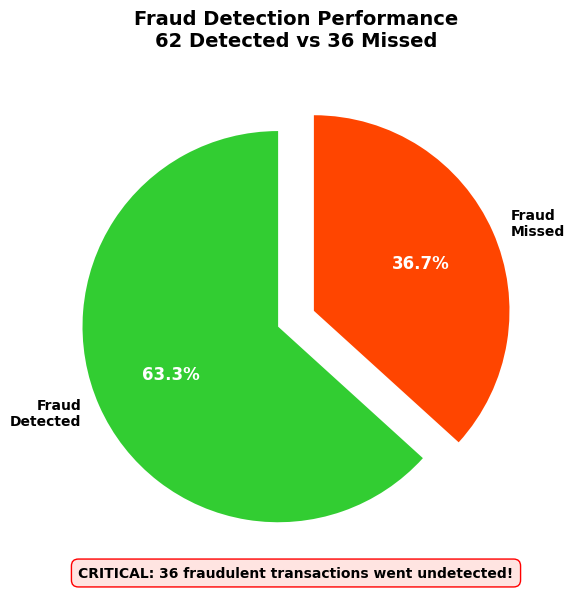


BASELINE MODEL ANALYSIS:
1. High accuracy (99.9%) is misleading due to class imbalance
2. Poor recall (63.3%) - model misses 36.7% of fraud cases
3. Only 62 out of 98 fraud cases detected
4. This baseline demonstrates the need for synthetic sampling techniques


In [13]:
# Train baseline Logistic Regression classifier on imbalanced data
print("\nTRAINING BASELINE LOGISTIC REGRESSION MODEL")

# Initialize and train the baseline model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Calculate performance metrics
precision_baseline = precision_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
auc_roc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

print("BASELINE MODEL PERFORMANCE:")
print(f"Accuracy:  {accuracy_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall:    {recall_baseline:.4f}")
print(f"F1-Score:  {f1_baseline:.4f}")
print(f"AUC-ROC:   {auc_roc_baseline:.4f}")

# Generate confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

print(f"\nConfusion Matrix:")
print(f"True Negatives:  {cm_baseline[0,0]:,}")
print(f"False Positives: {cm_baseline[0,1]:,}")
print(f"False Negatives: {cm_baseline[1,0]:,}")
print(f"True Positives:  {cm_baseline[1,1]:,}")

# Visual representation of fraud detection failure (smaller pie chart)
plt.figure(figsize=(6, 6))

fraud_detected = cm_baseline[1,1]
fraud_missed = cm_baseline[1,0]
total_fraud = fraud_detected + fraud_missed

categories = ['Fraud\nDetected', 'Fraud\nMissed']
values = [fraud_detected, fraud_missed]
colors = ['#32CD32', '#FF4500']  # Green for detected, Red for missed
explode = (0.1, 0.1)  # Explode the missed fraud slice for emphasis

wedges, texts, autotexts = plt.pie(values, labels=categories, autopct='%1.1f%%',
                                   colors=colors, explode=explode, startangle=90,
                                   textprops={'fontsize': 10, 'fontweight': 'bold'})

# Enhance the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.title(f'Fraud Detection Performance\n{fraud_detected} Detected vs {fraud_missed} Missed', 
          fontsize=14, fontweight='bold', pad=20)

# Add dramatic text annotation
plt.text(0, -1.3, f'CRITICAL: {fraud_missed} fraudulent transactions went undetected!', 
         ha='center', va='center', fontsize=10, fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor='#FFE4E1', edgecolor='red'))

plt.tight_layout()
plt.show()

# Analysis of baseline performance
print("\nBASELINE MODEL ANALYSIS:")
print(f"1. High accuracy ({accuracy_baseline:.1%}) is misleading due to class imbalance")
print(f"2. Poor recall ({recall_baseline:.1%}) - model misses {(1-recall_baseline):.1%} of fraud cases")
print(f"3. Only {cm_baseline[1,1]} out of {cm_baseline[1,0]+cm_baseline[1,1]} fraud cases detected")
print(f"4. This baseline demonstrates the need for synthetic sampling techniques")

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1. Theoretical Foundation: GMM vs SMOTE

#### **Fundamental Differences Between GMM and SMOTE**

**SMOTE (Synthetic Minority Oversampling Technique):**
- **Linear Interpolation**: Creates synthetic samples by linearly interpolating between existing minority samples and their k-nearest neighbors
- **Local Approach**: Only considers local neighborhoods around individual data points
- **Assumption**: Assumes that linear combinations of nearby points represent valid synthetic samples
- **Limitation**: Cannot capture complex, non-linear data distributions or multiple sub-populations

**GMM (Gaussian Mixture Model) Based Sampling:**
- **Probabilistic Modeling**: Models the entire minority class as a mixture of Gaussian distributions
- **Global Approach**: Captures the overall structure and distribution of the minority class
- **Flexibility**: Can represent complex, multi-modal distributions through multiple Gaussian components
- **Generative**: Learns the underlying probability distribution and generates new samples from it

#### **Why GMM is Theoretically Superior for Complex Data Distributions**

1. **Multi-Modal Distribution Handling**:
   - **SMOTE Problem**: When minority class has distinct sub-groups, SMOTE may create unrealistic samples in empty regions between clusters
   - **GMM Solution**: Each Gaussian component can model a different sub-group, ensuring synthetic samples are generated within appropriate regions

2. **Density-Aware Sampling**:
   - **SMOTE Limitation**: Generates samples uniformly along lines between points, ignoring data density
   - **GMM Advantage**: Samples are generated according to learned probability densities, respecting natural data concentration

3. **Complex Shape Representation**:
   - **SMOTE Constraint**: Limited to convex hull of nearest neighbors, cannot handle complex shapes
   - **GMM Flexibility**: Can model elliptical, curved, or irregular cluster shapes through covariance matrices

4. **Statistical Foundation**:
   - **SMOTE**: Heuristic approach based on geometric interpolation
   - **GMM**: Grounded in statistical theory with maximum likelihood estimation and rigorous mathematical foundation

#### **Mathematical Intuition**

For a minority class with data points **X = {x₁, x₂, ..., xₙ}**, GMM assumes:

**P(x) = Σᵢ₌₁ᵏ πᵢ · N(x | μᵢ, Σᵢ)**

Where:
- **k** = number of Gaussian components (sub-groups)
- **πᵢ** = mixing coefficient (weight) for component i
- **N(x | μᵢ, Σᵢ)** = Gaussian distribution with mean μᵢ and covariance Σᵢ

This allows GMM to:
- **Capture multiple sub-populations** through different components
- **Model varying cluster shapes** through different covariance matrices
- **Respect natural data density** through mixing coefficients
- **Generate realistic samples** by sampling from learned distributions

#### **Practical Implications for Fraud Detection**

In credit card fraud detection, fraudulent transactions may exhibit:
- **Multiple fraud patterns** (different types of fraudulent behavior)
- **Varying transaction characteristics** (amount, location, timing patterns)
- **Complex feature relationships** (non-linear dependencies between features)

GMM can model these complexities more accurately than SMOTE, leading to:
- **Better synthetic fraud samples** that respect genuine fraud patterns
- **Improved classifier training** on more realistic synthetic data
- **Enhanced generalization** to unseen fraud cases

FITTING GAUSSIAN MIXTURE MODEL TO MINORITY CLASS
Minority class training samples: 394
Feature dimensions: 30

Testing different numbers of GMM components...
k= 1: AIC=38470.36, BIC=40438.65, Log-Likelihood=  -47.56
k= 2: AIC=29212.65, BIC=33153.21, Log-Likelihood=  -34.56
k= 3: AIC=20195.65, BIC=26108.49, Log-Likelihood=  -21.85
k= 4: AIC=21449.13, BIC=29334.23, Log-Likelihood=  -22.19
k= 3: AIC=20195.65, BIC=26108.49, Log-Likelihood=  -21.85
k= 4: AIC=21449.13, BIC=29334.23, Log-Likelihood=  -22.19
k= 5: AIC=19964.82, BIC=29822.19, Log-Likelihood=  -19.04
k= 6: AIC=16520.84, BIC=28350.48, Log-Likelihood=  -13.41
k= 7: AIC=14205.62, BIC=28007.53, Log-Likelihood=   -9.22
k= 8: AIC=12645.51, BIC=28419.69, Log-Likelihood=   -5.98
k= 5: AIC=19964.82, BIC=29822.19, Log-Likelihood=  -19.04
k= 6: AIC=16520.84, BIC=28350.48, Log-Likelihood=  -13.41
k= 7: AIC=14205.62, BIC=28007.53, Log-Likelihood=   -9.22
k= 8: AIC=12645.51, BIC=28419.69, Log-Likelihood=   -5.98
k= 9: AIC=10624.75, BIC=28371.2

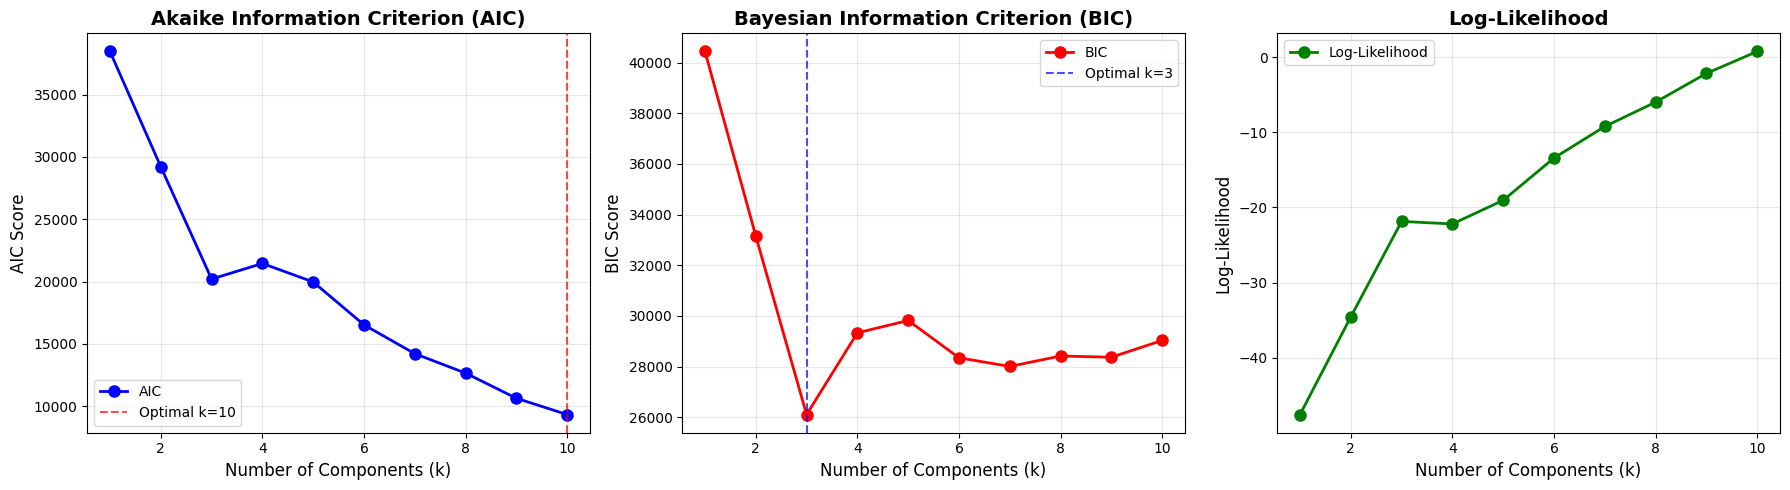


Final choice: k = 3 (based on BIC for model parsimony)

Fitting final GMM with 3 components...
GMM Training Results:
Converged: True
Number of iterations: 8
Log-likelihood: -21.8549

GMM Component Analysis:
Component 1: Weight = 0.0838 (8.4% of minority class)
Component 2: Weight = 0.2157 (21.6% of minority class)
Component 3: Weight = 0.7005 (70.1% of minority class)

GMM successfully fitted to minority class training data!


In [16]:
# Import GMM from sklearn
from sklearn.mixture import GaussianMixture

# Extract minority class samples from training data
minority_mask = y_train == 1
X_minority_train = X_train_scaled[minority_mask]

print("FITTING GAUSSIAN MIXTURE MODEL TO MINORITY CLASS")
print(f"Minority class training samples: {len(X_minority_train)}")
print(f"Feature dimensions: {X_minority_train.shape[1]}")

# Determine optimal number of components using AIC and BIC
k_range = range(1, 11)  # Test 1 to 10 components
aic_scores = []
bic_scores = []
log_likelihoods = []

print("\nTesting different numbers of GMM components...")
for k in k_range:
    # Fit GMM with k components
    gmm = GaussianMixture(n_components=k, random_state=42, max_iter=100)
    gmm.fit(X_minority_train)
    
    # Calculate AIC and BIC
    aic = gmm.aic(X_minority_train)
    bic = gmm.bic(X_minority_train)
    log_likelihood = gmm.score(X_minority_train)
    
    aic_scores.append(aic)
    bic_scores.append(bic)
    log_likelihoods.append(log_likelihood)
    
    print(f"k={k:2d}: AIC={aic:8.2f}, BIC={bic:8.2f}, Log-Likelihood={log_likelihood:8.2f}")

# Find optimal k for both criteria
optimal_k_aic = k_range[np.argmin(aic_scores)]
optimal_k_bic = k_range[np.argmin(bic_scores)]

print(f"\nOptimal number of components:")
print(f"Based on AIC: k = {optimal_k_aic}")
print(f"Based on BIC: k = {optimal_k_bic}")

# Visualize AIC and BIC scores
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot AIC scores
ax1.plot(k_range, aic_scores, 'bo-', linewidth=2, markersize=8, label='AIC')
ax1.axvline(x=optimal_k_aic, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k={optimal_k_aic}')
ax1.set_xlabel('Number of Components (k)', fontsize=12)
ax1.set_ylabel('AIC Score', fontsize=12)
ax1.set_title('Akaike Information Criterion (AIC)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot BIC scores
ax2.plot(k_range, bic_scores, 'ro-', linewidth=2, markersize=8, label='BIC')
ax2.axvline(x=optimal_k_bic, color='blue', linestyle='--', alpha=0.7, 
            label=f'Optimal k={optimal_k_bic}')
ax2.set_xlabel('Number of Components (k)', fontsize=12)
ax2.set_ylabel('BIC Score', fontsize=12)
ax2.set_title('Bayesian Information Criterion (BIC)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot Log-Likelihood
ax3.plot(k_range, log_likelihoods, 'go-', linewidth=2, markersize=8, label='Log-Likelihood')
ax3.set_xlabel('Number of Components (k)', fontsize=12)
ax3.set_ylabel('Log-Likelihood', fontsize=12)
ax3.set_title('Log-Likelihood', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

# Choose final k (prefer BIC as it's more conservative)
final_k = optimal_k_bic
print(f"\nFinal choice: k = {final_k} (based on BIC for model parsimony)")

# Fit final GMM with optimal number of components
print(f"\nFitting final GMM with {final_k} components...")
final_gmm = GaussianMixture(n_components=final_k, random_state=42, max_iter=200)
final_gmm.fit(X_minority_train)

print("GMM Training Results:")
print(f"Converged: {final_gmm.converged_}")
print(f"Number of iterations: {final_gmm.n_iter_}")
print(f"Log-likelihood: {final_gmm.score(X_minority_train):.4f}")

# Display component information
print(f"\nGMM Component Analysis:")
for i in range(final_k):
    weight = final_gmm.weights_[i]
    print(f"Component {i+1}: Weight = {weight:.4f} ({weight*100:.1f}% of minority class)")

print("\nGMM successfully fitted to minority class training data!")

### 2. Model Selection Criteria: AIC vs BIC

#### **Understanding Information Criteria**

**Akaike Information Criterion (AIC):**
- **Formula**: AIC = 2k - 2ln(L)
- **Purpose**: Balances model fit (likelihood) against model complexity (number of parameters)
- **Behavior**: Tends to favor more complex models; can lead to overfitting
- **Use Case**: When prediction accuracy is the primary concern

**Bayesian Information Criterion (BIC):**
- **Formula**: BIC = k·ln(n) - 2ln(L)
- **Purpose**: Similar to AIC but with stronger penalty for complexity
- **Behavior**: More conservative; favors simpler models
- **Use Case**: When model interpretability and generalization are important

Where:
- **k** = number of parameters in the model
- **L** = maximum likelihood of the model
- **n** = number of data points

#### **Why BIC is Preferred for GMM Component Selection**

1. **Overfitting Prevention**: BIC's stronger penalty prevents selecting too many components
2. **Generalization**: Simpler models typically generalize better to unseen data
3. **Interpretability**: Fewer components are easier to understand and visualize
4. **Computational Efficiency**: Fewer components mean faster synthetic sample generation

#### **GMM Parameter Count**

For a GMM with k components and d dimensions:
- **Means**: k × d parameters
- **Covariances**: k × d × (d+1)/2 parameters (for full covariance matrices)
- **Weights**: k-1 parameters (sum to 1 constraint)
- **Total**: k × d + k × d × (d+1)/2 + (k-1) parameters

This shows why the penalty term becomes significant for high-dimensional data!

In [ ]:
# Calculate how many synthetic samples needed to balance the dataset
majority_count = np.sum(y_train == 0)  # Non-fraud samples
minority_count = np.sum(y_train == 1)  # Fraud samples
samples_needed = majority_count - minority_count

print("SYNTHETIC DATA GENERATION WITH GMM")
print("=" * 60)
print(f"Current training set composition:")
print(f"  Non-fraud (majority): {majority_count:,} samples")
print(f"  Fraud (minority):     {minority_count:,} samples")
print(f"  Imbalance ratio:      {majority_count/minority_count:.1f}:1")
print(f"\nSynthetic samples needed: {samples_needed:,}")

# Generate synthetic samples using the fitted GMM
print(f"\nGenerating {samples_needed:,} synthetic fraud samples...")
synthetic_samples, component_labels = final_gmm.sample(samples_needed)

print("Synthetic sample generation completed!")
print(f"Generated samples shape: {synthetic_samples.shape}")

# Analyze which components generated the samples
component_counts = np.bincount(component_labels, minlength=final_k)
print(f"\nSamples generated from each GMM component:")
for i in range(final_k):
    percentage = (component_counts[i] / samples_needed) * 100
    print(f"  Component {i+1}: {component_counts[i]:,} samples ({percentage:.1f}%)")

# Create labels for synthetic samples (all are fraud = 1)
synthetic_labels = np.ones(samples_needed, dtype=int)

# Combine original training data with synthetic samples
print(f"\nCombining original and synthetic data...")

# Original training data
X_train_original = X_train_scaled.copy()
y_train_original = y_train.copy()

# Combine features
X_train_balanced = np.vstack([X_train_original, synthetic_samples])

# Combine labels  
y_train_balanced = np.hstack([y_train_original, synthetic_labels])

print(f"Balanced training set created!")
print(f"  Original samples:  {len(X_train_original):,}")
print(f"  Synthetic samples: {len(synthetic_samples):,}")
print(f"  Total samples:     {len(X_train_balanced):,}")

# Verify the balanced distribution
balanced_counts = np.bincount(y_train_balanced)
print(f"\nBalanced dataset composition:")
print(f"  Non-fraud: {balanced_counts[0]:,} samples ({balanced_counts[0]/len(y_train_balanced)*100:.1f}%)")
print(f"  Fraud:     {balanced_counts[1]:,} samples ({balanced_counts[1]/len(y_train_balanced)*100:.1f}%)")
print(f"  New ratio: {balanced_counts[0]/balanced_counts[1]:.2f}:1")

# Visualize the balancing effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original distribution
original_counts = [majority_count, minority_count]
original_labels = ['Non-fraud', 'Fraud']
colors = ['#219ebc', '#fb8500']

wedges1, texts1, autotexts1 = ax1.pie(original_counts, labels=original_labels, 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Original Training Data\n(Imbalanced)', fontsize=14, fontweight='bold')

# Balanced distribution  
balanced_labels_viz = ['Non-fraud', 'Fraud (Original)', 'Fraud (Synthetic)']
balanced_counts_viz = [balanced_counts[0], minority_count, samples_needed]
colors_balanced = ['#219ebc', '#fb8500', '#ff6b35']

wedges2, texts2, autotexts2 = ax2.pie(balanced_counts_viz, labels=balanced_labels_viz,
                                       autopct='%1.1f%%', colors=colors_balanced, startangle=90)
ax2.set_title('Balanced Training Data\n(After GMM Sampling)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 60)
print("DATASET SUCCESSFULLY BALANCED USING GMM SYNTHETIC SAMPLING!")
print("=" * 60)

### 3. GMM Sampling Process Explained

#### **How Synthetic Sample Generation Works**

The process of generating synthetic samples from a Gaussian Mixture Model involves several sophisticated steps:

#### **Step 1: Component Selection**
For each synthetic sample to be generated:
1. **Random component selection** based on learned mixing coefficients (πᵢ)
2. **Probability-weighted sampling**: Components with higher weights are selected more frequently
3. **Respects natural distribution**: Maintains the proportion of samples from each sub-group

#### **Step 2: Sample Generation from Selected Component**
Once a component is selected:
1. **Sample from Gaussian distribution**: Draw a sample from N(μᵢ, Σᵢ) for component i
2. **Multivariate sampling**: Considers correlations between features through covariance matrix
3. **Realistic sample creation**: Produces samples that follow learned statistical patterns

#### **Step 3: Mathematical Process**

For a GMM with k components, generating one synthetic sample involves:

```
1. Select component i with probability πᵢ
2. Generate sample x ~ N(μᵢ, Σᵢ)
3. Return x as synthetic sample
```

Where:
- **πᵢ** = mixing coefficient (weight) of component i
- **μᵢ** = mean vector of component i  
- **Σᵢ** = covariance matrix of component i
- **N(μᵢ, Σᵢ)** = multivariate Gaussian distribution

#### **Key Advantages of GMM Sampling**

1. **Density-Aware Generation**:
   - Samples are generated according to learned probability densities
   - High-density regions produce more samples naturally
   - Low-density regions produce fewer samples (avoiding outliers)

2. **Multi-Modal Support**:
   - Each component can model different fraud patterns
   - Synthetic samples respect distinct sub-groups in minority class
   - No unrealistic samples in empty regions between clusters

3. **Feature Correlation Preservation**:
   - Covariance matrices capture relationships between features
   - Synthetic samples maintain realistic feature interactions
   - Better than independent feature generation

4. **Statistical Validity**:
   - Generated samples follow learned statistical distributions
   - Maximum likelihood estimation ensures optimal parameter learning
   - Theoretical foundation for sample quality

#### **Why This Approach is Superior**

Compared to simpler methods like SMOTE:
- **No geometric constraints**: Not limited to convex hull of existing points
- **Probabilistic foundation**: Based on learned probability distributions
- **Handles complexity**: Can model non-linear, multi-modal distributions
- **Maintains realism**: Synthetic samples follow natural data patterns

This results in higher-quality synthetic samples that better represent the true underlying distribution of fraudulent transactions!